In [2]:
import chess
from chessboard import display
import numpy as np
import pandas as pd
import tensorflow as tf
import math

pygame 2.1.2 (SDL 2.0.18, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
abs_path="d:\OneDrive - Indian Institute of Technology Bombay\Study\Events and Activities\Year 2\Seasons of Coding 23\soc23-DeepCarlsen"
TotalPos = pd.read_csv(abs_path+"\dataset\chessDataEval.csv", )
TotalPos

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,+6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,+84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,+115


In [4]:
def cond(arr):
    pos = arr["FEN"].split()[0]
    res = pos.count('Q')>1 or pos.count('B')>2 or pos.count('N')>2 or pos.count('R')>2 or pos.count('q')>1 or pos.count('b')>2 or pos.count('n')>2 or pos.count('r')>2
    return not res
dataset_raw = TotalPos[TotalPos.apply(cond, axis = 1)]

In [5]:
dataset = dataset_raw.sample(10)
dataset.reset_index(inplace=True)
dataset = dataset.drop(["index"], axis=1)
dataset

,FEN,Evaluation
0,8/3k4/p2P4/P2K4/1p6/5N1p/8/8 w - - 0 55,#+18
1,b2rr1k1/p1q2pp1/2pNp2p/2Pn4/Q6P/PP4P1/5PB1/R3R...,+152
2,5rk1/p5rp/3p1nq1/2pP1p2/2P1pP2/P3N3/1R2Q1PP/1R...,0
3,2b5/5pkp/2r3p1/p7/PbR1N3/4P3/4B1PP/6K1 b - - 1 36,-205
4,8/8/3B2k1/8/4KP1P/8/4b3/8 b - - 0 46,+13
5,nr4k1/4p1bp/p2p2p1/PqpPp3/Nr2P3/4BP1P/1PQ2RP1/...,-37
6,r1n2rk1/4ppbp/b2p2p1/P1qP4/2p5/6P1/1PQBPPBP/1R...,+68
7,r1b1k2r/ppp3bp/n2p1np1/1N1P4/2P1Pp2/8/PP3BPP/2...,+31
8,r4rk1/1p4pp/4b3/p1Pp3q/1P1Qnp2/P2B1N2/5PPP/2KR...,+74
9,rn2kb1r/1bqppppp/5n2/1Bp5/8/1QN1P3/PP2NPPP/R1B...,+144


In [6]:
def features_global(arr):
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    white_play = (board.turn==chess.WHITE)
    K = board.has_kingside_castling_rights(chess.WHITE)
    k = board.has_kingside_castling_rights(chess.BLACK)
    Q = board.has_queenside_castling_rights(chess.WHITE)
    q = board.has_queenside_castling_rights(chess.BLACK)
    return [int(white_play),int(K), int(k), int(Q), int(q)]


In [7]:
def features_piece(arr):
    def p(symbol):
        return chess.Piece.from_symbol(symbol)
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    pieces_map = chess.Board.piece_map(board)
    emp = [-1,-1]
    piece_num = [0]*14
    piece_w = [emp]*16  # K Q B(light) B(dark) N N R R P P P P P P P P
    piece_b = [emp]*16  # k q b(light) b(dark) n n r r p p p p p p p p
    for (loc, pi) in pieces_map.items():
        if pi== p('k'):
            piece_b[0] = [loc%8,loc//8]
            piece_num[7]+=1
        elif pi== p('q'):
            piece_b[1] = [loc%8,loc//8]
            piece_num[8]+=1
        elif pi== p('b'):
            if((loc%8+loc//8)%2!=0):
                piece_b[2] = [loc%8,loc//8]
                piece_num[9]+=1
            else:
                piece_b[3] = [loc%8,loc//8]
                piece_num[10]+=1
        elif pi== p('n'):
            piece_b[piece_b[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[11]+=1
        elif pi== p('r'):
            piece_b[piece_b[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[12]+=1
        elif pi== p('p'):
            piece_b[piece_b[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[13]+=1

        elif pi== p('K'):
            piece_w[0] = [loc%8,loc//8]
            piece_num[0]+=1
        elif pi== p('Q'):
            piece_w[1] = [loc%8,loc//8]
            piece_num[1]+=1
        elif pi== p('B'):
            if((loc%8+loc//8)%2!=0):
                piece_w[2] = [loc%8,loc//8]
                piece_num[2]+=1
            else:
                piece_w[3] = [loc%8,loc//8]
                piece_num[3]+=1
        elif pi== p('N'):
            piece_w[piece_w[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[4]+=1
        elif pi== p('R'):
            piece_w[piece_w[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[5]+=1
        elif pi== p('P'):
            piece_w[piece_w[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[6]+=1
    result = piece_num+[item for sublist in piece_w for item in sublist]+[item for sublist in piece_b for item in sublist]
    return result


In [8]:
def features_map(arr):
    fen = arr if isinstance(arr, str) else arr["FEN"]
    piece_value = {6:1, 5:9, 3:3, 2:3, 4:5, 1:1}
    #piece_value = {6:0, 5:1340, 3:425, 2:450, 4:680, 1:110}
    board = chess.Board(fen)
    wht = []
    wht_count = []
    blk = []
    blk_count = []
    for sq in chess.SQUARES:   
        attks_white = chess.BaseBoard.attackers(board, chess.WHITE, sq)
        attks_black = chess.BaseBoard.attackers(board, chess.BLACK, sq)
        wht.append(0 if len(attks_white)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_white))
        blk.append(0 if len(attks_black)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_black))
        wht_count.append(len(attks_white))
        blk_count.append(len(attks_black))
    return wht_count+wht+blk_count+blk

In [9]:
def feat_ex(fen):
    f_centric = features_piece(fen)
    f_global = features_global(fen)
    f_map = features_map(fen)
    f_global.extend(f_centric[:14])
    f_centric=f_centric[14:]
    return f_global, f_centric, f_map

In [10]:
def tdleaf():
    input1 = tf.keras.Input(shape=(19))
    input2 = tf.keras.Input(shape=(64))
    input3 = tf.keras.Input(shape=(256))
    #flat3 = tf.keras.layers.Flatten()(input3)

    batch_1 = tf.keras.layers.BatchNormalization()(input1)
    batch_2 = tf.keras.layers.BatchNormalization()(input2)
    #batch_3 = tf.keras.layers.BatchNormalization()(flat3)

    in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(batch_1)
    in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)
    in3_layer = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(input3)

    concat_layer = tf.keras.layers.Concatenate()([in1_layer, in2_layer, in3_layer])

    hid1 = tf.keras.layers.Dense(units=92, activation=tf.nn.relu)(concat_layer)
    #hid2 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid1)
    #hid3 = tf.keras.layers.Dense(units=5, activation=tf.nn.relu)(hid2)
    out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid1)

    model = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)
    return model
eval_model = tdleaf()

In [11]:
def tens(arra):
    t =  tf.convert_to_tensor(np.asarray(arra).astype(np.float_))
    return tf.reshape(t,(1, len(t)))


In [12]:
x1,x2,x3 = feat_ex("6Q1/1p4nk/p7/P3p2q/1KPB4/1P6/8/8 b - - 1 53")
prev_res = eval_model([tens(el) for el in [x1,x2,x3]])
float(prev_res)

0.9049155712127686

In [20]:
batch_size = 2
num_epochs = 2
learning_rate = 5e-4
td_len = 1

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = []

def step(dataset, model):
    def best_move(board, model):
        turn = int(board.turn==chess.WHITE)
        moves_set = board.legal_moves
        moves_set2 = []
        eval_set = []
        try:
            for move in moves_set:
                board.push(move)
                fen = board.fen()
                x1,x2,x3 = feat_ex(fen)
                eval_set.append(model([tens(el) for el in [x1,x2,x3]]))
                moves_set2.append(move)
                board.pop()
        except:
            return move, 7000
        res = max(eval_set)
        bmove = moves_set2[eval_set.index(res)]
        return bmove, res
             
    with tf.GradientTape() as tape:
        loss_list = 0
        for row, element in dataset.iterrows():
            board = chess.Board(element["FEN"])
            fen = board.fen()
            x1,x2,x3 = feat_ex(fen)
            prev_res = float(model([tens(el) for el in [x1,x2,x3]])[0][0])
            y_temp = int(element["Evaluation"])/10000 if '#' not in element["Evaluation"] else 1 if '+' in element["Evaluation"] else -1
            loss = prev_res-y_temp
            lmda = 0.7

            #for move_td in range(td_len):
             #   bmove, res = best_move(board, model)
              #  board.push(bmove)
               # loss = lmda*loss+(res-prev_res)**2
                #prev_res = res
            loss_list = loss_list+loss
    grads = tape.gradient(tf.convert_to_tensor(loss_list/len(dataset), dtype=tf.float32), model.trainable_variables)
    print(grads)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_list/len(dataset)

# The training loop!
for epoch in range(num_epochs):
  for idx in range(len(dataset)//batch_size):
    # Grab a batch of training data and propagate through the network
    loss = step(dataset, eval_model)
    print("Epoch="+str(epoch)+"/"+str(num_epochs)+"      idx*b="+str(idx*batch_size)+"/"+str(1000)+"      Loss="+str(loss))
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())

loss_history

[None, None, None, None, None, None, None, None, None, None, None, None, None, None]


ValueError: No gradients provided for any variable: (['batch_normalization/gamma:0', 'batch_normalization/beta:0', 'batch_normalization_1/gamma:0', 'batch_normalization_1/beta:0', 'dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'batch_normalization/gamma:0' shape=(19,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization/beta:0' shape=(19,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_1/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense/kernel:0' shape=(19, 19) dtype=float32, numpy=
array([[ 2.67158121e-01, -2.29079828e-01, -1.48719549e-02,
         3.86737794e-01,  1.82744175e-01, -3.68126512e-01,
         3.04241091e-01,  3.82236689e-01, -3.33912551e-01,
        -7.08981752e-02,  1.86821967e-01, -1.55165106e-01,
        -3.01229596e-01, -2.23546848e-01,  9.77111757e-02,
         7.89057016e-02,  1.93191856e-01,  3.90496582e-01,
        -2.10678414e-01],
       [ 6.46730363e-02,  4.29111719e-02, -3.39246988e-02,
         5.25377691e-02, -3.77353519e-01, -2.85696089e-01,
        -8.89773965e-02,  6.90463185e-02, -1.89855397e-01,
        -1.21742129e-01,  1.87096506e-01, -2.50707924e-01,
         3.01800072e-02, -2.51566052e-01, -6.78514838e-02,
         1.22365326e-01,  3.89828414e-01,  7.51250982e-02,
        -3.80514532e-01],
       [ 3.19877893e-01, -1.15746647e-01, -3.24147940e-01,
        -3.42267126e-01, -1.17249668e-01, -2.69926280e-01,
        -1.82111800e-01, -2.95321077e-01,  2.75115460e-01,
         7.53523707e-02, -3.84333909e-01, -2.98765272e-01,
        -1.93433076e-01,  1.86015874e-01,  3.65379781e-01,
        -3.06087077e-01, -2.70018280e-02, -2.46947780e-01,
         3.29142779e-01],
       [ 3.33251387e-01,  3.65261465e-01,  1.67057008e-01,
        -2.74749190e-01,  2.57606000e-01,  3.47132593e-01,
        -1.06294453e-01,  4.00639176e-02,  5.53188920e-02,
         3.77595395e-01,  2.87922055e-01,  2.71574885e-01,
        -2.05210701e-01, -1.89533755e-01,  5.62895834e-02,
         9.84695554e-02,  3.13825905e-02,  2.48247892e-01,
         2.88041025e-01],
       [-2.63850749e-01,  1.94780231e-02,  2.49369115e-01,
         1.60814315e-01, -1.28423423e-01,  2.27540225e-01,
         3.65740657e-02,  2.52579004e-01,  1.67730361e-01,
        -1.20016485e-01, -2.08184630e-01, -2.59136677e-01,
        -3.45211953e-01,  2.88648874e-01,  1.71129674e-01,
         2.74170607e-01, -1.45276070e-01,  2.64135897e-02,
         1.44171715e-03],
       [-1.61748156e-01, -1.59130648e-01, -3.70620668e-01,
        -6.43005371e-02, -3.23803723e-02, -3.78296912e-01,
         3.20152372e-01, -1.82162106e-01, -2.39987195e-01,
         1.43165320e-01, -1.40615076e-01, -2.65327811e-01,
        -1.10037059e-01,  1.87328368e-01,  2.91939676e-02,
        -2.14402467e-01, -2.82165110e-01,  3.63173336e-01,
        -2.54042238e-01],
       [ 1.16686434e-01,  1.04909927e-01,  8.16321671e-02,
         9.99799669e-02,  1.02672786e-01, -6.57044649e-02,
        -1.73119366e-01, -3.69150043e-01,  1.58877403e-01,
        -7.24333227e-02,  3.34849358e-02,  3.52616221e-01,
        -3.87158990e-01,  3.53514045e-01,  3.70693833e-01,
        -6.54706359e-02, -6.02489710e-02,  1.44595116e-01,
         3.65984172e-01],
       [-1.45280719e-01, -1.87596560e-01, -2.65906274e-01,
         4.37791646e-02,  3.34616870e-01,  1.94425374e-01,
         3.11516255e-01,  3.71067077e-01,  3.33148390e-01,
        -1.43597513e-01, -1.76705122e-02, -2.34276205e-01,
        -3.42897415e-01,  8.93213749e-02, -1.51776701e-01,
        -3.91633213e-02, -3.11578661e-01, -2.14816272e-01,
         3.61136943e-01],
       [-2.80867279e-01,  4.57482040e-02,  3.94215077e-01,
         1.64042801e-01,  2.83258468e-01, -2.44063959e-01,
         3.11248988e-01, -2.93068290e-01,  2.83897191e-01,
         2.08743602e-01, -1.22126967e-01, -3.19064498e-01,
        -3.76663536e-01,  3.80586356e-01, -3.34441960e-01,
         1.74803644e-01, -3.76097381e-01,  3.79653871e-02,
         2.78387040e-01],
       [ 2.46015936e-01,  4.93788421e-02, -1.21975482e-01,
         3.14871103e-01,  1.99663252e-01,  2.17178077e-01,
         3.78410488e-01, -2.34103501e-01,  2.14620143e-01,
        -3.03252339e-02, -1.31621301e-01,  2.28801399e-01,
        -3.50941241e-01,  3.55289966e-01,  1.02778941e-01,
        -8.43077898e-04,  9.74255800e-03, -8.61178339e-02,
        -5.66014647e-02],
       [ 3.70130807e-01,  2.90972799e-01,  7.20717013e-02,
        -2.55909145e-01, -1.11956447e-01,  2.59304345e-02,
         3.92198563e-05, -1.87994242e-02,  4.13068831e-02,
         3.62009734e-01, -3.57230306e-02, -5.98516464e-02,
        -2.44108483e-01, -4.44444120e-02, -1.66987360e-01,
         2.91596085e-01, -8.07311237e-02, -3.68489176e-01,
         1.21721774e-01],
       [ 6.57512546e-02, -8.05901587e-02,  1.05225444e-02,
         2.56796807e-01,  3.21417183e-01,  2.58496732e-01,
        -2.88940936e-01, -3.55082810e-01, -5.22001386e-02,
         2.81756669e-01,  4.29969132e-02, -3.51767629e-01,
         2.22418875e-01,  2.63683528e-01, -2.66679138e-01,
         2.20556557e-02,  6.38327301e-02,  2.88882762e-01,
        -4.81010079e-02],
       [ 1.87789232e-01, -2.10718960e-01, -3.51987064e-01,
        -1.98842227e-01,  2.72399396e-01, -1.04057312e-01,
         2.06444263e-02,  1.99904889e-01, -1.43523216e-02,
        -2.14927316e-01,  7.42258430e-02,  1.66872829e-01,
         3.91252428e-01,  1.44781560e-01,  4.93660569e-02,
        -1.52571648e-01, -5.93861938e-02,  3.25395554e-01,
         1.51945561e-01],
       [-2.03979313e-02,  4.95879054e-02, -4.83871996e-02,
         1.99558705e-01, -3.78602922e-01, -2.34068260e-01,
        -1.43849850e-03,  6.17839992e-02, -6.10136092e-02,
         2.34807760e-01, -1.02773309e-01,  3.48053724e-01,
        -1.08024925e-01, -1.40047371e-02,  1.45048827e-01,
        -7.45843351e-02,  3.69464666e-01,  1.07355982e-01,
         3.43736708e-02],
       [-2.72975713e-01, -3.94577533e-01, -1.76784769e-01,
         2.26458520e-01, -3.84182423e-01, -1.40519857e-01,
         2.57567436e-01,  2.21616119e-01,  3.17544907e-01,
         9.16980803e-02,  3.63674492e-01, -1.03072971e-01,
        -2.48040497e-01, -3.16925943e-01,  1.79507166e-01,
        -2.72435218e-01,  3.55189472e-01, -3.78964633e-01,
         2.34913796e-01],
       [ 7.91262686e-02, -5.02488017e-02,  2.26680487e-01,
        -3.57692927e-01, -3.76210690e-01, -1.30493641e-01,
        -3.76406401e-01,  3.90643626e-01,  3.36159199e-01,
         2.71542042e-01,  2.41001457e-01,  3.17335695e-01,
        -1.92149088e-01,  1.13112479e-01, -9.47046280e-03,
         9.71186161e-02, -2.71947414e-01, -1.09305322e-01,
         9.26651657e-02],
       [-1.64931267e-01, -9.39993560e-02,  7.37139881e-02,
        -2.63600647e-02,  2.11723357e-01,  4.97242510e-02,
         3.08742791e-01, -2.64838099e-01, -3.59163076e-01,
         3.09835583e-01,  8.05046856e-02,  5.24262786e-02,
        -3.64045858e-01,  3.43846291e-01,  2.86999345e-03,
        -2.81790793e-01,  1.49262160e-01, -2.25945115e-02,
        -2.95101166e-01],
       [-5.29873967e-02,  1.47229582e-01, -2.63917148e-02,
         2.23978966e-01, -3.68740976e-01, -1.00221068e-01,
        -2.84318119e-01,  1.76386386e-01, -1.99367553e-01,
         2.95889527e-01, -1.23542249e-01, -3.26935053e-02,
         5.49846590e-02, -1.34240538e-01, -3.69596839e-01,
         1.30087107e-01,  3.97169679e-01,  3.35005254e-01,
         2.50592619e-01],
       [ 3.32723528e-01,  2.63145775e-01, -1.29869223e-01,
        -1.60863876e-01,  1.87285691e-01,  1.22240156e-01,
         3.81767422e-01,  2.05369323e-01, -2.98916936e-01,
        -3.19350600e-01, -1.21035963e-01,  3.38807195e-01,
         1.15077764e-01,  4.27293777e-02, -1.35016739e-02,
         2.44204670e-01, -1.45000488e-01, -1.25951797e-01,
        -2.04344094e-02]], dtype=float32)>), (None, <tf.Variable 'dense/bias:0' shape=(19,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_1/kernel:0' shape=(64, 64) dtype=float32, numpy=
array([[-0.19458422, -0.0851595 , -0.17545757, ...,  0.1078461 ,
         0.00474761,  0.07973318],
       [ 0.0126487 , -0.13213027,  0.18551333, ...,  0.04104786,
         0.09495173, -0.17498086],
       [ 0.20880307,  0.10029398, -0.10990803, ..., -0.01578601,
         0.19698213, -0.03408939],
       ...,
       [ 0.17537959, -0.12748595, -0.21202834, ...,  0.05063291,
        -0.21034591, -0.0196607 ],
       [ 0.11892395,  0.08304332,  0.17103939, ...,  0.10765202,
        -0.1977478 , -0.1266081 ],
       [ 0.05705808, -0.01903455, -0.17595394, ...,  0.16103993,
        -0.15206595, -0.17731741]], dtype=float32)>), (None, <tf.Variable 'dense_1/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_2/kernel:0' shape=(256, 256) dtype=float32, numpy=
array([[-0.10289536,  0.09874135, -0.00093769, ..., -0.07681069,
        -0.04273641,  0.04775242],
       [ 0.09700543, -0.08810423, -0.09008623, ...,  0.05444068,
        -0.05993759,  0.02841946],
       [-0.08603986, -0.07156242,  0.01612806, ...,  0.06516465,
        -0.07396403,  0.00362049],
       ...,
       [ 0.0203423 ,  0.00255788, -0.03367206, ...,  0.04354265,
         0.08167406,  0.06159324],
       [ 0.06108663,  0.07060107,  0.03200956, ...,  0.10794736,
        -0.05114865, -0.04506523],
       [-0.01804383, -0.04395057, -0.01042758, ...,  0.0548358 ,
         0.05374274, -0.03495073]], dtype=float32)>), (None, <tf.Variable 'dense_2/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>), (None, <tf.Variable 'dense_3/kernel:0' shape=(339, 92) dtype=float32, numpy=
array([[ 0.09453578,  0.05479926, -0.1136406 , ..., -0.07537091,
        -0.10084742, -0.11667444],
       [-0.01241502, -0.03711192,  0.06418322, ..., -0.07766712,
        -0.01838445, -0.05472601],
       [ 0.04174158, -0.0329996 , -0.00881024, ...,  0.05405305,
        -0.05094609,  0.04284963],
       ...,
       [ 0.02798223, -0.08136231,  0.03525837, ...,  0.0578045 ,
        -0.10654862, -0.01398934],
       [-0.11370932, -0.09277577, -0.0094333 , ..., -0.11122292,
         0.09545596, -0.09843222],
       [ 0.01390323, -0.04368902,  0.08413161, ..., -0.10176723,
        -0.00640013,  0.07304478]], dtype=float32)>), (None, <tf.Variable 'dense_3/bias:0' shape=(92,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_4/kernel:0' shape=(92, 1) dtype=float32, numpy=
array([[-0.24574347],
       [ 0.2124165 ],
       [ 0.20175931],
       [ 0.24018657],
       [-0.08672239],
       [ 0.17243066],
       [-0.03286169],
       [ 0.00209841],
       [-0.13549204],
       [-0.00835384],
       [ 0.17297551],
       [ 0.23852703],
       [-0.08847451],
       [ 0.1514717 ],
       [ 0.19094098],
       [-0.08243836],
       [ 0.24829555],
       [ 0.1744358 ],
       [ 0.17341393],
       [ 0.12508217],
       [ 0.19763875],
       [ 0.15060207],
       [ 0.13156524],
       [ 0.16393521],
       [-0.0707939 ],
       [ 0.18534255],
       [-0.14841653],
       [-0.236885  ],
       [ 0.04321754],
       [ 0.01323262],
       [-0.06665649],
       [ 0.0092001 ],
       [ 0.06380945],
       [-0.03448424],
       [ 0.17377609],
       [-0.17037724],
       [ 0.07351631],
       [-0.09291139],
       [-0.2076    ],
       [ 0.10783407],
       [-0.08001924],
       [-0.2377769 ],
       [ 0.13582662],
       [ 0.06811866],
       [-0.02949739],
       [-0.00118428],
       [-0.1783087 ],
       [-0.10204971],
       [-0.05215245],
       [-0.22193919],
       [-0.13809097],
       [-0.13043833],
       [ 0.05080429],
       [-0.15512785],
       [ 0.2053456 ],
       [-0.09361556],
       [ 0.05622923],
       [ 0.16909268],
       [ 0.121288  ],
       [ 0.18620199],
       [ 0.2434532 ],
       [-0.1473114 ],
       [ 0.15638897],
       [-0.03430843],
       [ 0.04372865],
       [-0.22665481],
       [-0.10454248],
       [-0.00048357],
       [-0.02881992],
       [-0.00938776],
       [ 0.21649656],
       [ 0.15446153],
       [ 0.17256841],
       [-0.09767739],
       [ 0.13000637],
       [ 0.06529579],
       [ 0.01746178],
       [-0.22652982],
       [ 0.05876634],
       [ 0.1934016 ],
       [ 0.01705396],
       [ 0.00952002],
       [-0.00554176],
       [ 0.04678959],
       [ 0.22758317],
       [ 0.03490785],
       [-0.12846158],
       [ 0.08620581],
       [-0.22444327],
       [-0.13576674],
       [ 0.09562409],
       [-0.0371387 ]], dtype=float32)>), (None, <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)).

In [ ]:
batch_size = 2
num_epochs = 2
learning_rate = 5e-4
td_len = 1

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = []

def step(dataset, model):
    return 0
    return loss_list/len(dataset)

# The training loop!
for epoch in range(num_epochs):
  for idx in range(len(dataset)//batch_size):
    # Grab a batch of training data and propagate through the network

    def best_move(board, model):
        turn = int(board.turn==chess.WHITE)
        moves_set = board.legal_moves
        moves_set2 = []
        eval_set = []
        #try:
        for move in moves_set:
            board.push(move)
            fen = board.fen()
            x1,x2,x3 = feat_ex(fen)
            eval_set.append(eval_model([tens(el) for el in [x1,x2,x3]]))
            moves_set2.append(move)
            board.pop()
        #except:
            #return move, 7000
        res = max(eval_set) if turn else min(eval_set)
        bmove = moves_set2[eval_set.index(res)]
        return bmove, res
             
    with tf.GradientTape() as tape:
        #tape.watch(eval_model.trainable_variables)
        loss_list = 0
        for row, element in dataset.iterrows():
            with tape.stop_recording():
                board = chess.Board(element["FEN"])
                fen = board.fen()
                x1,x2,x3 = feat_ex(fen)
            prev_res = eval_model([tens(el) for el in [x1,x2,x3]])
            with tape.stop_recording():
                loss = 0
                lmda = 0.7
                #for move_td in range(td_len):
                bmove, res = best_move(board, eval_model)
                board.push(bmove)
                loss = lmda*loss+(res-prev_res)**2
                prev_res = res
                loss_list+=loss
    total_loss = loss_list/len(dataset)
    grads = tape.gradient(total_loss, eval_model.trainable_variables)
    print(grads)
    print(total_loss)
    optimizer.apply_gradients(zip(grads, eval_model.trainable_variables))
    print("Epoch="+str(epoch)+"/"+str(num_epochs)+"      idx*b="+str(idx*batch_size)+"/"+str(1000)+"      Loss="+str(total_loss))
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(total_loss)

loss_history

NameError: name 'tf' is not defined

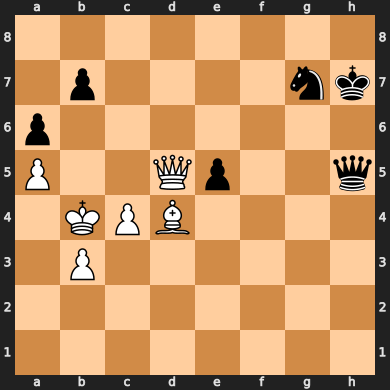

In [ ]:
chess.Board("6Q1/1p4nk/p7/P3p2q/1KPB4/1P6/8/8 b - - 1 53")
chess.Board("8/1p4nk/p7/P2Qp2q/1KPB4/1P6/8/8 w - - 0 53")

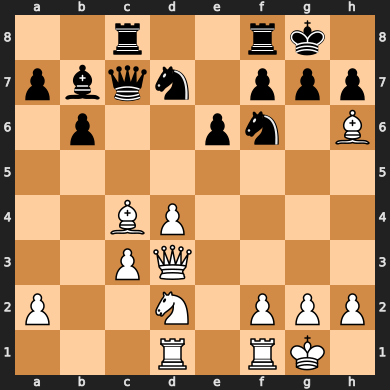

In [ ]:
chess.Board("2r2rk1/pbqn1ppp/1p2pn1B/8/2BP4/2PQ4/P2N1PPP/3R1RK1")